# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

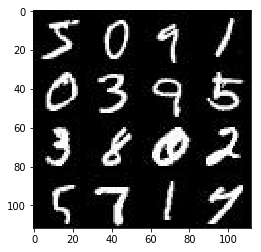

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

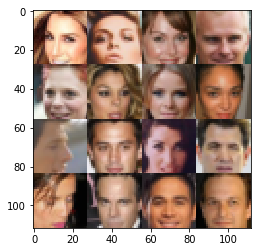

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return input_images, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    #Putting 4 instead of 3 convolutional layers seems to drive the generator loss lower than the discriminator loss more efficiently.
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x0 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x0 = tf.maximum(alpha * x0, x0)
                
        x1 = tf.layers.conv2d(x0, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.7)
        
        x2 = tf.layers.conv2d(x1, filters=256, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.7)
        
        x3 = tf.layers.conv2d(x2, filters=512, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.7)

        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x0 = tf.layers.dense(z, 7*7*512)

        x0 = tf.reshape(x0, (-1, 7, 7, 512))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)

        x1 = tf.layers.conv2d_transpose(x0, filters=256, kernel_size=5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
       
        output = tf.tanh(logits) 
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    g_vars = [x for x in train_vars if x.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_num, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 #Necessary to change range from -0.5 till 0.5 to -1 till 1
                                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) #generates random noise for the generator

                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                # Calculate losses and print them out after each 10 steps
                steps +=1 
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} -- ".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f} -- ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                #Print image
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 --  Discriminator Loss: 0.6392 --  Generator Loss: 5.9618
Epoch 1/2 --  Discriminator Loss: 0.3783 --  Generator Loss: 5.4126
Epoch 1/2 --  Discriminator Loss: 2.2044 --  Generator Loss: 2.7800
Epoch 1/2 --  Discriminator Loss: 1.6272 --  Generator Loss: 0.8074
Epoch 1/2 --  Discriminator Loss: 1.2756 --  Generator Loss: 2.7563
Epoch 1/2 --  Discriminator Loss: 2.0605 --  Generator Loss: 0.6659
Epoch 1/2 --  Discriminator Loss: 1.9452 --  Generator Loss: 0.3989
Epoch 1/2 --  Discriminator Loss: 1.4725 --  Generator Loss: 0.7141
Epoch 1/2 --  Discriminator Loss: 1.9021 --  Generator Loss: 0.5969
Epoch 1/2 --  Discriminator Loss: 1.6707 --  Generator Loss: 1.1118


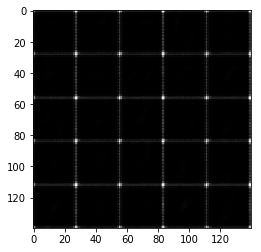

Epoch 1/2 --  Discriminator Loss: 2.3889 --  Generator Loss: 0.8499
Epoch 1/2 --  Discriminator Loss: 1.2155 --  Generator Loss: 0.8258
Epoch 1/2 --  Discriminator Loss: 1.7190 --  Generator Loss: 0.7791
Epoch 1/2 --  Discriminator Loss: 2.0412 --  Generator Loss: 0.8189
Epoch 1/2 --  Discriminator Loss: 2.0736 --  Generator Loss: 1.7589
Epoch 1/2 --  Discriminator Loss: 1.6198 --  Generator Loss: 0.7374
Epoch 1/2 --  Discriminator Loss: 1.8122 --  Generator Loss: 0.4417
Epoch 1/2 --  Discriminator Loss: 1.5035 --  Generator Loss: 0.5351
Epoch 1/2 --  Discriminator Loss: 1.7131 --  Generator Loss: 0.7249
Epoch 1/2 --  Discriminator Loss: 1.4902 --  Generator Loss: 0.8292


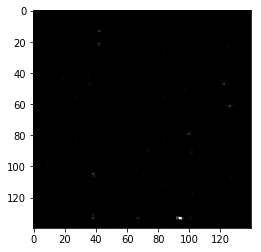

Epoch 1/2 --  Discriminator Loss: 1.3296 --  Generator Loss: 0.8337
Epoch 1/2 --  Discriminator Loss: 1.5977 --  Generator Loss: 0.6352
Epoch 1/2 --  Discriminator Loss: 1.9219 --  Generator Loss: 0.9297
Epoch 1/2 --  Discriminator Loss: 1.7654 --  Generator Loss: 0.6084
Epoch 1/2 --  Discriminator Loss: 1.4216 --  Generator Loss: 0.7672
Epoch 1/2 --  Discriminator Loss: 1.6165 --  Generator Loss: 1.0419
Epoch 1/2 --  Discriminator Loss: 1.1932 --  Generator Loss: 1.4831
Epoch 1/2 --  Discriminator Loss: 1.6816 --  Generator Loss: 0.5658
Epoch 1/2 --  Discriminator Loss: 1.7256 --  Generator Loss: 0.8611
Epoch 1/2 --  Discriminator Loss: 1.6070 --  Generator Loss: 0.7778


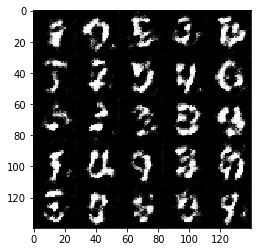

Epoch 1/2 --  Discriminator Loss: 1.7224 --  Generator Loss: 0.6892
Epoch 1/2 --  Discriminator Loss: 1.7232 --  Generator Loss: 0.6476
Epoch 1/2 --  Discriminator Loss: 1.5642 --  Generator Loss: 0.5875
Epoch 1/2 --  Discriminator Loss: 1.7421 --  Generator Loss: 0.4311
Epoch 1/2 --  Discriminator Loss: 1.2008 --  Generator Loss: 1.0120
Epoch 1/2 --  Discriminator Loss: 1.6299 --  Generator Loss: 0.6675
Epoch 1/2 --  Discriminator Loss: 1.3134 --  Generator Loss: 0.6586
Epoch 1/2 --  Discriminator Loss: 1.5267 --  Generator Loss: 0.9141
Epoch 1/2 --  Discriminator Loss: 1.3525 --  Generator Loss: 1.0671
Epoch 1/2 --  Discriminator Loss: 1.3889 --  Generator Loss: 0.7940


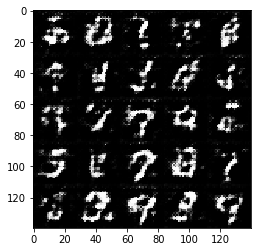

Epoch 1/2 --  Discriminator Loss: 1.9417 --  Generator Loss: 0.4616
Epoch 1/2 --  Discriminator Loss: 1.3747 --  Generator Loss: 1.0669
Epoch 1/2 --  Discriminator Loss: 1.2835 --  Generator Loss: 0.7159
Epoch 1/2 --  Discriminator Loss: 2.2479 --  Generator Loss: 2.6099
Epoch 1/2 --  Discriminator Loss: 1.1897 --  Generator Loss: 1.1018
Epoch 1/2 --  Discriminator Loss: 1.8142 --  Generator Loss: 1.4113
Epoch 1/2 --  Discriminator Loss: 1.5511 --  Generator Loss: 0.8871
Epoch 1/2 --  Discriminator Loss: 1.2467 --  Generator Loss: 0.7178
Epoch 1/2 --  Discriminator Loss: 1.3607 --  Generator Loss: 0.9050
Epoch 1/2 --  Discriminator Loss: 1.2603 --  Generator Loss: 0.7584


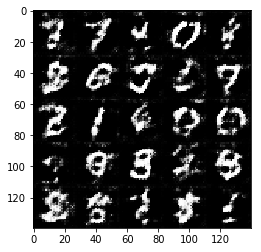

Epoch 1/2 --  Discriminator Loss: 1.7209 --  Generator Loss: 1.0402
Epoch 1/2 --  Discriminator Loss: 2.1130 --  Generator Loss: 0.3768
Epoch 1/2 --  Discriminator Loss: 1.7325 --  Generator Loss: 0.7990
Epoch 1/2 --  Discriminator Loss: 1.2760 --  Generator Loss: 0.5828
Epoch 1/2 --  Discriminator Loss: 1.3951 --  Generator Loss: 0.7115
Epoch 1/2 --  Discriminator Loss: 1.5705 --  Generator Loss: 0.4185
Epoch 1/2 --  Discriminator Loss: 2.0256 --  Generator Loss: 0.4691
Epoch 1/2 --  Discriminator Loss: 1.4664 --  Generator Loss: 0.6814
Epoch 1/2 --  Discriminator Loss: 1.8677 --  Generator Loss: 2.0509
Epoch 1/2 --  Discriminator Loss: 1.5918 --  Generator Loss: 0.4947


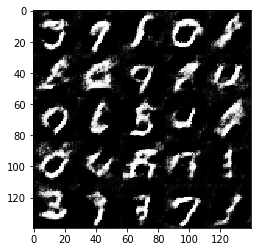

Epoch 1/2 --  Discriminator Loss: 1.4795 --  Generator Loss: 0.8093
Epoch 1/2 --  Discriminator Loss: 1.6402 --  Generator Loss: 0.5172
Epoch 1/2 --  Discriminator Loss: 1.6376 --  Generator Loss: 0.4865
Epoch 1/2 --  Discriminator Loss: 1.3837 --  Generator Loss: 0.9355
Epoch 1/2 --  Discriminator Loss: 1.1377 --  Generator Loss: 0.7353
Epoch 1/2 --  Discriminator Loss: 1.4452 --  Generator Loss: 0.6407
Epoch 1/2 --  Discriminator Loss: 1.2140 --  Generator Loss: 1.1395
Epoch 1/2 --  Discriminator Loss: 1.4695 --  Generator Loss: 0.6126
Epoch 1/2 --  Discriminator Loss: 1.5660 --  Generator Loss: 0.6806
Epoch 1/2 --  Discriminator Loss: 1.5611 --  Generator Loss: 0.5587


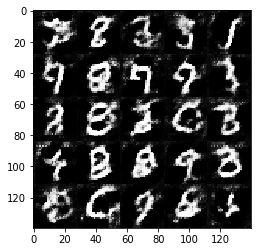

Epoch 1/2 --  Discriminator Loss: 1.7087 --  Generator Loss: 0.5293
Epoch 1/2 --  Discriminator Loss: 1.4994 --  Generator Loss: 0.8922
Epoch 1/2 --  Discriminator Loss: 1.7100 --  Generator Loss: 0.7519
Epoch 1/2 --  Discriminator Loss: 1.7154 --  Generator Loss: 0.8208
Epoch 1/2 --  Discriminator Loss: 1.4326 --  Generator Loss: 1.0951
Epoch 1/2 --  Discriminator Loss: 1.2743 --  Generator Loss: 1.2107
Epoch 1/2 --  Discriminator Loss: 1.5154 --  Generator Loss: 1.3921
Epoch 1/2 --  Discriminator Loss: 1.4286 --  Generator Loss: 0.7592
Epoch 1/2 --  Discriminator Loss: 1.5515 --  Generator Loss: 0.7990
Epoch 1/2 --  Discriminator Loss: 1.6223 --  Generator Loss: 0.5319


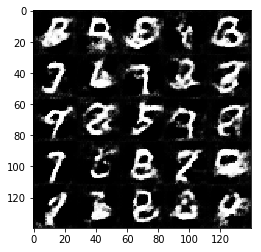

Epoch 1/2 --  Discriminator Loss: 1.3978 --  Generator Loss: 0.8334
Epoch 1/2 --  Discriminator Loss: 1.4647 --  Generator Loss: 0.4592
Epoch 1/2 --  Discriminator Loss: 1.5282 --  Generator Loss: 1.0266
Epoch 1/2 --  Discriminator Loss: 1.4971 --  Generator Loss: 0.6162
Epoch 1/2 --  Discriminator Loss: 1.2306 --  Generator Loss: 1.6422
Epoch 1/2 --  Discriminator Loss: 1.5009 --  Generator Loss: 0.5856
Epoch 1/2 --  Discriminator Loss: 1.6918 --  Generator Loss: 1.4468
Epoch 1/2 --  Discriminator Loss: 1.1809 --  Generator Loss: 1.0856
Epoch 1/2 --  Discriminator Loss: 1.3684 --  Generator Loss: 0.6162
Epoch 1/2 --  Discriminator Loss: 1.4992 --  Generator Loss: 0.7335


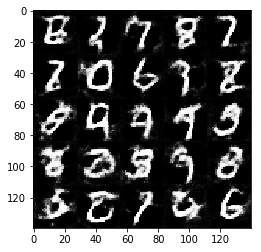

Epoch 1/2 --  Discriminator Loss: 1.1872 --  Generator Loss: 1.1183
Epoch 1/2 --  Discriminator Loss: 1.3693 --  Generator Loss: 0.5841
Epoch 1/2 --  Discriminator Loss: 1.3917 --  Generator Loss: 0.7569
Epoch 2/2 --  Discriminator Loss: 1.1594 --  Generator Loss: 1.0941
Epoch 2/2 --  Discriminator Loss: 1.2616 --  Generator Loss: 0.9016
Epoch 2/2 --  Discriminator Loss: 1.4712 --  Generator Loss: 0.9609
Epoch 2/2 --  Discriminator Loss: 1.3705 --  Generator Loss: 0.9718
Epoch 2/2 --  Discriminator Loss: 1.6614 --  Generator Loss: 0.3613
Epoch 2/2 --  Discriminator Loss: 1.2537 --  Generator Loss: 1.4527
Epoch 2/2 --  Discriminator Loss: 1.4126 --  Generator Loss: 0.7108


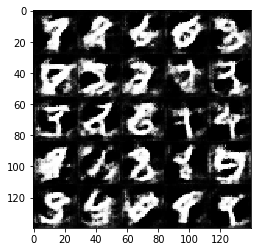

Epoch 2/2 --  Discriminator Loss: 1.4593 --  Generator Loss: 0.5793
Epoch 2/2 --  Discriminator Loss: 1.2757 --  Generator Loss: 0.7007
Epoch 2/2 --  Discriminator Loss: 1.2545 --  Generator Loss: 1.0885
Epoch 2/2 --  Discriminator Loss: 1.5290 --  Generator Loss: 1.5234
Epoch 2/2 --  Discriminator Loss: 1.0574 --  Generator Loss: 1.1477
Epoch 2/2 --  Discriminator Loss: 1.0971 --  Generator Loss: 0.6188
Epoch 2/2 --  Discriminator Loss: 1.2396 --  Generator Loss: 1.3329
Epoch 2/2 --  Discriminator Loss: 0.9924 --  Generator Loss: 0.9213
Epoch 2/2 --  Discriminator Loss: 1.2631 --  Generator Loss: 1.0000
Epoch 2/2 --  Discriminator Loss: 1.2202 --  Generator Loss: 1.0429


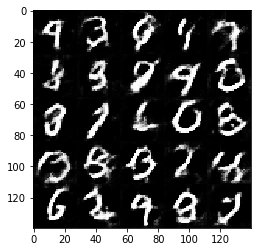

Epoch 2/2 --  Discriminator Loss: 1.0555 --  Generator Loss: 1.1278
Epoch 2/2 --  Discriminator Loss: 1.1861 --  Generator Loss: 0.8558
Epoch 2/2 --  Discriminator Loss: 1.2306 --  Generator Loss: 0.8175
Epoch 2/2 --  Discriminator Loss: 1.6006 --  Generator Loss: 0.4159
Epoch 2/2 --  Discriminator Loss: 1.5962 --  Generator Loss: 0.4544
Epoch 2/2 --  Discriminator Loss: 1.2462 --  Generator Loss: 0.7847
Epoch 2/2 --  Discriminator Loss: 1.1964 --  Generator Loss: 1.0213
Epoch 2/2 --  Discriminator Loss: 1.3619 --  Generator Loss: 0.8599
Epoch 2/2 --  Discriminator Loss: 1.6515 --  Generator Loss: 0.5983
Epoch 2/2 --  Discriminator Loss: 1.4183 --  Generator Loss: 0.6110


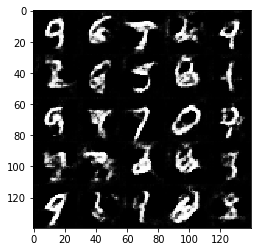

Epoch 2/2 --  Discriminator Loss: 1.4051 --  Generator Loss: 0.6701
Epoch 2/2 --  Discriminator Loss: 1.3578 --  Generator Loss: 1.2990
Epoch 2/2 --  Discriminator Loss: 1.1209 --  Generator Loss: 0.9368
Epoch 2/2 --  Discriminator Loss: 1.5888 --  Generator Loss: 0.6329
Epoch 2/2 --  Discriminator Loss: 1.4246 --  Generator Loss: 0.8342
Epoch 2/2 --  Discriminator Loss: 1.2804 --  Generator Loss: 0.6450
Epoch 2/2 --  Discriminator Loss: 1.5439 --  Generator Loss: 0.5892
Epoch 2/2 --  Discriminator Loss: 1.3938 --  Generator Loss: 0.6379
Epoch 2/2 --  Discriminator Loss: 1.3148 --  Generator Loss: 1.5725
Epoch 2/2 --  Discriminator Loss: 1.2075 --  Generator Loss: 0.8184


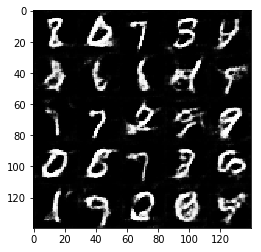

Epoch 2/2 --  Discriminator Loss: 1.6164 --  Generator Loss: 0.4452
Epoch 2/2 --  Discriminator Loss: 1.7207 --  Generator Loss: 1.0930
Epoch 2/2 --  Discriminator Loss: 1.3744 --  Generator Loss: 1.0652
Epoch 2/2 --  Discriminator Loss: 1.4736 --  Generator Loss: 0.4945
Epoch 2/2 --  Discriminator Loss: 1.2661 --  Generator Loss: 0.7687
Epoch 2/2 --  Discriminator Loss: 1.4907 --  Generator Loss: 0.6205
Epoch 2/2 --  Discriminator Loss: 1.2667 --  Generator Loss: 0.7535
Epoch 2/2 --  Discriminator Loss: 1.1772 --  Generator Loss: 0.8523
Epoch 2/2 --  Discriminator Loss: 1.3212 --  Generator Loss: 1.1673
Epoch 2/2 --  Discriminator Loss: 1.2943 --  Generator Loss: 0.8591


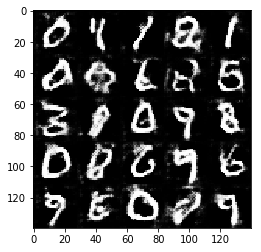

Epoch 2/2 --  Discriminator Loss: 1.3365 --  Generator Loss: 0.8415
Epoch 2/2 --  Discriminator Loss: 1.3487 --  Generator Loss: 1.0151
Epoch 2/2 --  Discriminator Loss: 1.6231 --  Generator Loss: 0.4511
Epoch 2/2 --  Discriminator Loss: 1.0044 --  Generator Loss: 1.4653
Epoch 2/2 --  Discriminator Loss: 1.3191 --  Generator Loss: 1.6720
Epoch 2/2 --  Discriminator Loss: 1.3428 --  Generator Loss: 1.7335
Epoch 2/2 --  Discriminator Loss: 1.3329 --  Generator Loss: 1.0209
Epoch 2/2 --  Discriminator Loss: 1.5120 --  Generator Loss: 0.4564
Epoch 2/2 --  Discriminator Loss: 1.3304 --  Generator Loss: 0.7447
Epoch 2/2 --  Discriminator Loss: 1.7008 --  Generator Loss: 0.5378


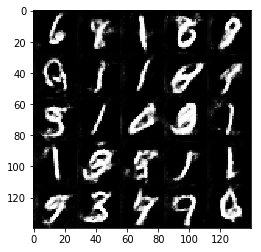

Epoch 2/2 --  Discriminator Loss: 1.4647 --  Generator Loss: 0.4455
Epoch 2/2 --  Discriminator Loss: 1.1536 --  Generator Loss: 0.7395
Epoch 2/2 --  Discriminator Loss: 1.2778 --  Generator Loss: 0.5574
Epoch 2/2 --  Discriminator Loss: 1.1134 --  Generator Loss: 1.1601
Epoch 2/2 --  Discriminator Loss: 1.3104 --  Generator Loss: 0.5744
Epoch 2/2 --  Discriminator Loss: 1.4731 --  Generator Loss: 1.5024
Epoch 2/2 --  Discriminator Loss: 1.4673 --  Generator Loss: 0.4551
Epoch 2/2 --  Discriminator Loss: 1.5008 --  Generator Loss: 0.4876
Epoch 2/2 --  Discriminator Loss: 1.6874 --  Generator Loss: 0.4922
Epoch 2/2 --  Discriminator Loss: 1.4049 --  Generator Loss: 1.2632


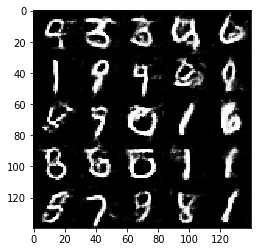

Epoch 2/2 --  Discriminator Loss: 1.4018 --  Generator Loss: 0.7726
Epoch 2/2 --  Discriminator Loss: 1.0471 --  Generator Loss: 0.9866
Epoch 2/2 --  Discriminator Loss: 1.5775 --  Generator Loss: 0.5206
Epoch 2/2 --  Discriminator Loss: 1.6716 --  Generator Loss: 0.6631
Epoch 2/2 --  Discriminator Loss: 1.3790 --  Generator Loss: 1.0064
Epoch 2/2 --  Discriminator Loss: 1.2656 --  Generator Loss: 0.6885
Epoch 2/2 --  Discriminator Loss: 1.3226 --  Generator Loss: 0.8228
Epoch 2/2 --  Discriminator Loss: 1.3703 --  Generator Loss: 1.3098
Epoch 2/2 --  Discriminator Loss: 1.3868 --  Generator Loss: 0.8883
Epoch 2/2 --  Discriminator Loss: 1.7098 --  Generator Loss: 0.4550


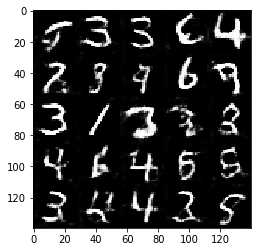

Epoch 2/2 --  Discriminator Loss: 1.3900 --  Generator Loss: 0.6694
Epoch 2/2 --  Discriminator Loss: 1.4033 --  Generator Loss: 1.7269
Epoch 2/2 --  Discriminator Loss: 1.4061 --  Generator Loss: 0.4472
Epoch 2/2 --  Discriminator Loss: 1.4930 --  Generator Loss: 1.6207
Epoch 2/2 --  Discriminator Loss: 1.2331 --  Generator Loss: 0.9663
Epoch 2/2 --  Discriminator Loss: 1.2823 --  Generator Loss: 1.1681
Epoch 2/2 --  Discriminator Loss: 1.4192 --  Generator Loss: 0.6248
Epoch 2/2 --  Discriminator Loss: 1.2465 --  Generator Loss: 0.6044
Epoch 2/2 --  Discriminator Loss: 1.1463 --  Generator Loss: 0.9082
Epoch 2/2 --  Discriminator Loss: 1.5001 --  Generator Loss: 0.6897


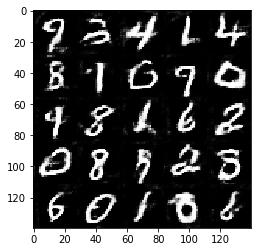

Epoch 2/2 --  Discriminator Loss: 1.4072 --  Generator Loss: 0.6309
Epoch 2/2 --  Discriminator Loss: 1.2020 --  Generator Loss: 1.0089
Epoch 2/2 --  Discriminator Loss: 1.4157 --  Generator Loss: 0.5646
Epoch 2/2 --  Discriminator Loss: 1.3411 --  Generator Loss: 0.7175
Epoch 2/2 --  Discriminator Loss: 1.6196 --  Generator Loss: 0.4515
Epoch 2/2 --  Discriminator Loss: 1.5373 --  Generator Loss: 0.4626
Epoch 2/2 --  Discriminator Loss: 1.2773 --  Generator Loss: 0.7334


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 --  Discriminator Loss: 0.4569 --  Generator Loss: 3.8369
Epoch 1/1 --  Discriminator Loss: 1.0634 --  Generator Loss: 1.1658
Epoch 1/1 --  Discriminator Loss: 0.6125 --  Generator Loss: 2.3458
Epoch 1/1 --  Discriminator Loss: 0.7428 --  Generator Loss: 6.4317
Epoch 1/1 --  Discriminator Loss: 1.8683 --  Generator Loss: 0.3762
Epoch 1/1 --  Discriminator Loss: 1.6544 --  Generator Loss: 0.4836
Epoch 1/1 --  Discriminator Loss: 1.4711 --  Generator Loss: 0.9593
Epoch 1/1 --  Discriminator Loss: 2.0661 --  Generator Loss: 0.4401
Epoch 1/1 --  Discriminator Loss: 1.8877 --  Generator Loss: 0.8924
Epoch 1/1 --  Discriminator Loss: 2.0659 --  Generator Loss: 0.3428


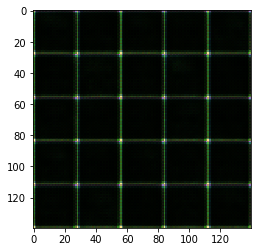

Epoch 1/1 --  Discriminator Loss: 0.9653 --  Generator Loss: 3.7153
Epoch 1/1 --  Discriminator Loss: 2.4753 --  Generator Loss: 0.3575
Epoch 1/1 --  Discriminator Loss: 2.1882 --  Generator Loss: 0.3744
Epoch 1/1 --  Discriminator Loss: 2.1273 --  Generator Loss: 0.2627
Epoch 1/1 --  Discriminator Loss: 1.2987 --  Generator Loss: 2.3978
Epoch 1/1 --  Discriminator Loss: 0.9805 --  Generator Loss: 1.3333
Epoch 1/1 --  Discriminator Loss: 1.1594 --  Generator Loss: 1.7499
Epoch 1/1 --  Discriminator Loss: 1.4288 --  Generator Loss: 0.8005
Epoch 1/1 --  Discriminator Loss: 1.4350 --  Generator Loss: 0.4687
Epoch 1/1 --  Discriminator Loss: 1.0649 --  Generator Loss: 1.7651


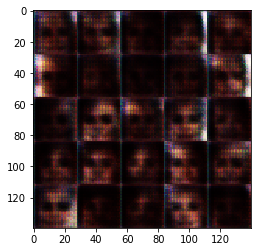

Epoch 1/1 --  Discriminator Loss: 0.8457 --  Generator Loss: 1.9011
Epoch 1/1 --  Discriminator Loss: 0.8668 --  Generator Loss: 3.1719
Epoch 1/1 --  Discriminator Loss: 0.9817 --  Generator Loss: 1.2992
Epoch 1/1 --  Discriminator Loss: 0.8669 --  Generator Loss: 1.2322
Epoch 1/1 --  Discriminator Loss: 1.6471 --  Generator Loss: 3.7161
Epoch 1/1 --  Discriminator Loss: 1.5392 --  Generator Loss: 0.6110
Epoch 1/1 --  Discriminator Loss: 0.8718 --  Generator Loss: 2.1413
Epoch 1/1 --  Discriminator Loss: 1.1087 --  Generator Loss: 0.7887
Epoch 1/1 --  Discriminator Loss: 1.2184 --  Generator Loss: 0.8836
Epoch 1/1 --  Discriminator Loss: 2.6372 --  Generator Loss: 3.6347


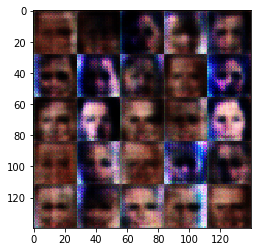

Epoch 1/1 --  Discriminator Loss: 1.1029 --  Generator Loss: 2.1055
Epoch 1/1 --  Discriminator Loss: 1.1867 --  Generator Loss: 1.4531
Epoch 1/1 --  Discriminator Loss: 1.1085 --  Generator Loss: 1.4838
Epoch 1/1 --  Discriminator Loss: 2.1414 --  Generator Loss: 0.4978
Epoch 1/1 --  Discriminator Loss: 0.6440 --  Generator Loss: 2.6781
Epoch 1/1 --  Discriminator Loss: 1.4021 --  Generator Loss: 0.6724
Epoch 1/1 --  Discriminator Loss: 1.2296 --  Generator Loss: 3.0274
Epoch 1/1 --  Discriminator Loss: 2.4481 --  Generator Loss: 0.2203
Epoch 1/1 --  Discriminator Loss: 1.3096 --  Generator Loss: 0.9267
Epoch 1/1 --  Discriminator Loss: 1.7585 --  Generator Loss: 0.7155


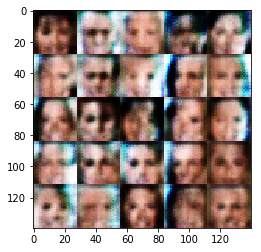

Epoch 1/1 --  Discriminator Loss: 0.9888 --  Generator Loss: 3.6007
Epoch 1/1 --  Discriminator Loss: 1.5889 --  Generator Loss: 2.0932
Epoch 1/1 --  Discriminator Loss: 0.8024 --  Generator Loss: 2.1234
Epoch 1/1 --  Discriminator Loss: 0.8375 --  Generator Loss: 1.5770
Epoch 1/1 --  Discriminator Loss: 0.6454 --  Generator Loss: 2.1660
Epoch 1/1 --  Discriminator Loss: 1.6393 --  Generator Loss: 0.3689
Epoch 1/1 --  Discriminator Loss: 1.3182 --  Generator Loss: 0.8541
Epoch 1/1 --  Discriminator Loss: 2.0731 --  Generator Loss: 0.2068
Epoch 1/1 --  Discriminator Loss: 1.1782 --  Generator Loss: 1.0235
Epoch 1/1 --  Discriminator Loss: 2.0514 --  Generator Loss: 0.3567


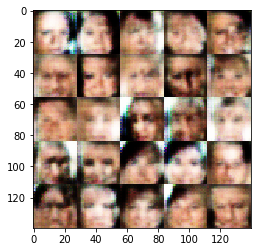

Epoch 1/1 --  Discriminator Loss: 0.7831 --  Generator Loss: 1.1539
Epoch 1/1 --  Discriminator Loss: 1.1120 --  Generator Loss: 1.2337
Epoch 1/1 --  Discriminator Loss: 1.5482 --  Generator Loss: 0.4810
Epoch 1/1 --  Discriminator Loss: 0.8442 --  Generator Loss: 1.0473
Epoch 1/1 --  Discriminator Loss: 1.0901 --  Generator Loss: 4.5465
Epoch 1/1 --  Discriminator Loss: 0.8291 --  Generator Loss: 1.7045
Epoch 1/1 --  Discriminator Loss: 1.1869 --  Generator Loss: 0.8681
Epoch 1/1 --  Discriminator Loss: 1.0218 --  Generator Loss: 1.0737
Epoch 1/1 --  Discriminator Loss: 1.0154 --  Generator Loss: 0.9169
Epoch 1/1 --  Discriminator Loss: 1.4434 --  Generator Loss: 1.2654


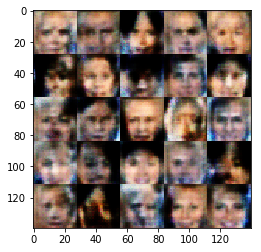

Epoch 1/1 --  Discriminator Loss: 0.8826 --  Generator Loss: 1.6413
Epoch 1/1 --  Discriminator Loss: 1.0608 --  Generator Loss: 1.3818
Epoch 1/1 --  Discriminator Loss: 1.0568 --  Generator Loss: 0.6269
Epoch 1/1 --  Discriminator Loss: 0.8633 --  Generator Loss: 1.4981
Epoch 1/1 --  Discriminator Loss: 2.9011 --  Generator Loss: 2.1890
Epoch 1/1 --  Discriminator Loss: 1.3319 --  Generator Loss: 0.7118
Epoch 1/1 --  Discriminator Loss: 0.8052 --  Generator Loss: 1.2552
Epoch 1/1 --  Discriminator Loss: 1.4717 --  Generator Loss: 2.3214
Epoch 1/1 --  Discriminator Loss: 1.6715 --  Generator Loss: 0.5766
Epoch 1/1 --  Discriminator Loss: 1.5342 --  Generator Loss: 0.7470


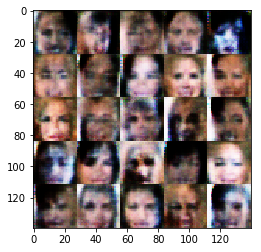

Epoch 1/1 --  Discriminator Loss: 1.3171 --  Generator Loss: 0.7721
Epoch 1/1 --  Discriminator Loss: 0.5718 --  Generator Loss: 2.8503
Epoch 1/1 --  Discriminator Loss: 1.0218 --  Generator Loss: 1.4343
Epoch 1/1 --  Discriminator Loss: 0.8486 --  Generator Loss: 1.9115
Epoch 1/1 --  Discriminator Loss: 1.3544 --  Generator Loss: 0.5781
Epoch 1/1 --  Discriminator Loss: 1.9276 --  Generator Loss: 2.0009
Epoch 1/1 --  Discriminator Loss: 1.1021 --  Generator Loss: 0.9793
Epoch 1/1 --  Discriminator Loss: 1.2162 --  Generator Loss: 0.8358
Epoch 1/1 --  Discriminator Loss: 1.1911 --  Generator Loss: 0.9175
Epoch 1/1 --  Discriminator Loss: 1.3448 --  Generator Loss: 1.6913


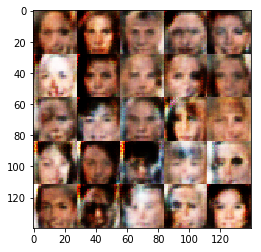

Epoch 1/1 --  Discriminator Loss: 0.8731 --  Generator Loss: 1.4152
Epoch 1/1 --  Discriminator Loss: 0.9686 --  Generator Loss: 1.2745
Epoch 1/1 --  Discriminator Loss: 1.3248 --  Generator Loss: 0.7036
Epoch 1/1 --  Discriminator Loss: 1.4016 --  Generator Loss: 3.3806
Epoch 1/1 --  Discriminator Loss: 1.2446 --  Generator Loss: 0.8278
Epoch 1/1 --  Discriminator Loss: 1.2652 --  Generator Loss: 1.6714
Epoch 1/1 --  Discriminator Loss: 1.5721 --  Generator Loss: 0.5125
Epoch 1/1 --  Discriminator Loss: 1.4072 --  Generator Loss: 1.2204
Epoch 1/1 --  Discriminator Loss: 1.4449 --  Generator Loss: 0.6999
Epoch 1/1 --  Discriminator Loss: 1.7536 --  Generator Loss: 0.4461


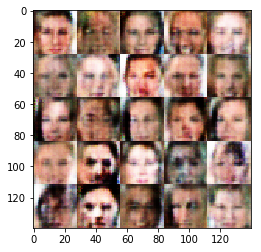

Epoch 1/1 --  Discriminator Loss: 1.1941 --  Generator Loss: 1.2893
Epoch 1/1 --  Discriminator Loss: 1.3757 --  Generator Loss: 0.9557
Epoch 1/1 --  Discriminator Loss: 1.3515 --  Generator Loss: 1.0435
Epoch 1/1 --  Discriminator Loss: 1.5065 --  Generator Loss: 0.6412
Epoch 1/1 --  Discriminator Loss: 1.0989 --  Generator Loss: 1.2983
Epoch 1/1 --  Discriminator Loss: 1.1517 --  Generator Loss: 0.9453
Epoch 1/1 --  Discriminator Loss: 1.1443 --  Generator Loss: 0.9659
Epoch 1/1 --  Discriminator Loss: 1.2459 --  Generator Loss: 2.9324
Epoch 1/1 --  Discriminator Loss: 1.4513 --  Generator Loss: 0.4973
Epoch 1/1 --  Discriminator Loss: 0.9767 --  Generator Loss: 1.0924


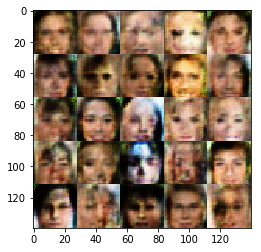

Epoch 1/1 --  Discriminator Loss: 0.7711 --  Generator Loss: 1.4931
Epoch 1/1 --  Discriminator Loss: 1.1715 --  Generator Loss: 1.0219
Epoch 1/1 --  Discriminator Loss: 1.2064 --  Generator Loss: 0.7414
Epoch 1/1 --  Discriminator Loss: 1.3673 --  Generator Loss: 0.6956
Epoch 1/1 --  Discriminator Loss: 1.3388 --  Generator Loss: 0.7587
Epoch 1/1 --  Discriminator Loss: 1.8093 --  Generator Loss: 0.2738
Epoch 1/1 --  Discriminator Loss: 1.4205 --  Generator Loss: 0.8644
Epoch 1/1 --  Discriminator Loss: 1.0980 --  Generator Loss: 1.0946
Epoch 1/1 --  Discriminator Loss: 1.1246 --  Generator Loss: 1.3738
Epoch 1/1 --  Discriminator Loss: 0.9984 --  Generator Loss: 1.2716


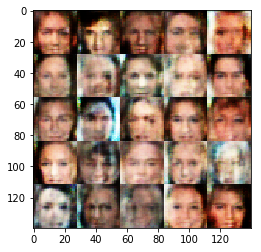

Epoch 1/1 --  Discriminator Loss: 1.2535 --  Generator Loss: 0.7035
Epoch 1/1 --  Discriminator Loss: 1.2541 --  Generator Loss: 1.2025
Epoch 1/1 --  Discriminator Loss: 1.1833 --  Generator Loss: 0.7540
Epoch 1/1 --  Discriminator Loss: 1.1895 --  Generator Loss: 1.4194
Epoch 1/1 --  Discriminator Loss: 1.2852 --  Generator Loss: 0.9421
Epoch 1/1 --  Discriminator Loss: 1.5216 --  Generator Loss: 1.7394
Epoch 1/1 --  Discriminator Loss: 0.5992 --  Generator Loss: 1.6542
Epoch 1/1 --  Discriminator Loss: 1.3953 --  Generator Loss: 1.7247
Epoch 1/1 --  Discriminator Loss: 1.1157 --  Generator Loss: 1.3401
Epoch 1/1 --  Discriminator Loss: 0.8547 --  Generator Loss: 1.7238


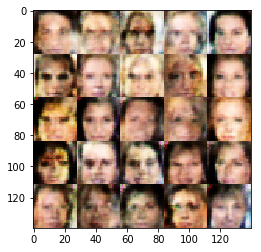

Epoch 1/1 --  Discriminator Loss: 1.2939 --  Generator Loss: 0.4862
Epoch 1/1 --  Discriminator Loss: 0.9481 --  Generator Loss: 1.1701
Epoch 1/1 --  Discriminator Loss: 0.8353 --  Generator Loss: 1.6675
Epoch 1/1 --  Discriminator Loss: 0.9577 --  Generator Loss: 1.1238
Epoch 1/1 --  Discriminator Loss: 1.3887 --  Generator Loss: 0.8868
Epoch 1/1 --  Discriminator Loss: 0.6347 --  Generator Loss: 1.5161
Epoch 1/1 --  Discriminator Loss: 1.2006 --  Generator Loss: 2.2972
Epoch 1/1 --  Discriminator Loss: 1.5117 --  Generator Loss: 0.3125
Epoch 1/1 --  Discriminator Loss: 1.2244 --  Generator Loss: 1.7483
Epoch 1/1 --  Discriminator Loss: 1.6454 --  Generator Loss: 0.4434


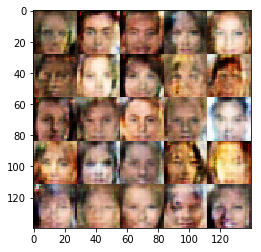

Epoch 1/1 --  Discriminator Loss: 0.7335 --  Generator Loss: 1.3777
Epoch 1/1 --  Discriminator Loss: 0.8686 --  Generator Loss: 1.1619
Epoch 1/1 --  Discriminator Loss: 0.7187 --  Generator Loss: 1.3775
Epoch 1/1 --  Discriminator Loss: 1.1753 --  Generator Loss: 0.6425
Epoch 1/1 --  Discriminator Loss: 0.9256 --  Generator Loss: 1.1582
Epoch 1/1 --  Discriminator Loss: 1.1599 --  Generator Loss: 1.0568
Epoch 1/1 --  Discriminator Loss: 1.0826 --  Generator Loss: 1.4720
Epoch 1/1 --  Discriminator Loss: 0.8755 --  Generator Loss: 0.8997
Epoch 1/1 --  Discriminator Loss: 2.6972 --  Generator Loss: 0.1471
Epoch 1/1 --  Discriminator Loss: 1.1979 --  Generator Loss: 0.6527


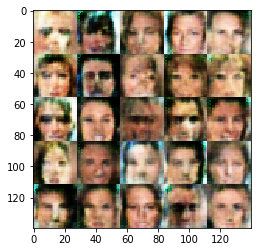

Epoch 1/1 --  Discriminator Loss: 1.3466 --  Generator Loss: 1.1504
Epoch 1/1 --  Discriminator Loss: 0.7988 --  Generator Loss: 1.5469
Epoch 1/1 --  Discriminator Loss: 1.4612 --  Generator Loss: 0.4851
Epoch 1/1 --  Discriminator Loss: 1.2191 --  Generator Loss: 0.7594
Epoch 1/1 --  Discriminator Loss: 1.1728 --  Generator Loss: 2.3281
Epoch 1/1 --  Discriminator Loss: 1.3424 --  Generator Loss: 0.7793
Epoch 1/1 --  Discriminator Loss: 1.5711 --  Generator Loss: 0.6138
Epoch 1/1 --  Discriminator Loss: 0.8167 --  Generator Loss: 1.9778
Epoch 1/1 --  Discriminator Loss: 0.9346 --  Generator Loss: 1.7779
Epoch 1/1 --  Discriminator Loss: 1.6743 --  Generator Loss: 0.4534


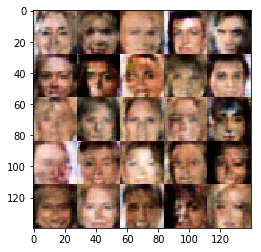

Epoch 1/1 --  Discriminator Loss: 1.0432 --  Generator Loss: 0.8212
Epoch 1/1 --  Discriminator Loss: 1.2522 --  Generator Loss: 0.9595
Epoch 1/1 --  Discriminator Loss: 0.9715 --  Generator Loss: 0.9614
Epoch 1/1 --  Discriminator Loss: 1.5388 --  Generator Loss: 0.4109
Epoch 1/1 --  Discriminator Loss: 1.5223 --  Generator Loss: 1.6805
Epoch 1/1 --  Discriminator Loss: 1.1814 --  Generator Loss: 1.5081
Epoch 1/1 --  Discriminator Loss: 1.3347 --  Generator Loss: 0.5263
Epoch 1/1 --  Discriminator Loss: 0.6140 --  Generator Loss: 1.5894
Epoch 1/1 --  Discriminator Loss: 1.5027 --  Generator Loss: 1.4439
Epoch 1/1 --  Discriminator Loss: 0.7373 --  Generator Loss: 1.9492


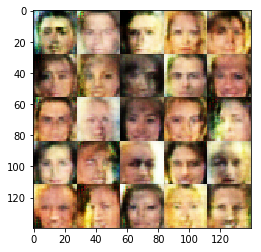

Epoch 1/1 --  Discriminator Loss: 1.3735 --  Generator Loss: 0.6088
Epoch 1/1 --  Discriminator Loss: 1.1168 --  Generator Loss: 1.1523
Epoch 1/1 --  Discriminator Loss: 1.4642 --  Generator Loss: 0.7657
Epoch 1/1 --  Discriminator Loss: 1.3471 --  Generator Loss: 0.6824
Epoch 1/1 --  Discriminator Loss: 1.3116 --  Generator Loss: 0.8080
Epoch 1/1 --  Discriminator Loss: 1.9396 --  Generator Loss: 2.1297
Epoch 1/1 --  Discriminator Loss: 0.8459 --  Generator Loss: 1.0651
Epoch 1/1 --  Discriminator Loss: 1.9439 --  Generator Loss: 2.2219
Epoch 1/1 --  Discriminator Loss: 1.2794 --  Generator Loss: 0.8285
Epoch 1/1 --  Discriminator Loss: 0.7232 --  Generator Loss: 1.2547


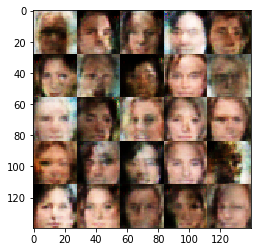

Epoch 1/1 --  Discriminator Loss: 1.5577 --  Generator Loss: 0.4810
Epoch 1/1 --  Discriminator Loss: 0.8941 --  Generator Loss: 1.1381
Epoch 1/1 --  Discriminator Loss: 1.2815 --  Generator Loss: 0.9539
Epoch 1/1 --  Discriminator Loss: 2.3321 --  Generator Loss: 0.1838
Epoch 1/1 --  Discriminator Loss: 0.9382 --  Generator Loss: 1.3150
Epoch 1/1 --  Discriminator Loss: 1.6477 --  Generator Loss: 1.6076
Epoch 1/1 --  Discriminator Loss: 0.9076 --  Generator Loss: 1.9308
Epoch 1/1 --  Discriminator Loss: 1.5862 --  Generator Loss: 0.5049
Epoch 1/1 --  Discriminator Loss: 1.1241 --  Generator Loss: 1.0088
Epoch 1/1 --  Discriminator Loss: 0.9890 --  Generator Loss: 0.9176


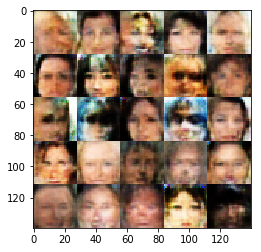

Epoch 1/1 --  Discriminator Loss: 1.3737 --  Generator Loss: 0.4559
Epoch 1/1 --  Discriminator Loss: 1.3257 --  Generator Loss: 1.3679
Epoch 1/1 --  Discriminator Loss: 1.2659 --  Generator Loss: 0.6386
Epoch 1/1 --  Discriminator Loss: 1.2405 --  Generator Loss: 1.5286
Epoch 1/1 --  Discriminator Loss: 2.0187 --  Generator Loss: 0.1851
Epoch 1/1 --  Discriminator Loss: 1.2044 --  Generator Loss: 0.6826
Epoch 1/1 --  Discriminator Loss: 0.6931 --  Generator Loss: 1.5245
Epoch 1/1 --  Discriminator Loss: 0.7889 --  Generator Loss: 1.4303
Epoch 1/1 --  Discriminator Loss: 0.8178 --  Generator Loss: 1.9603
Epoch 1/1 --  Discriminator Loss: 0.7597 --  Generator Loss: 1.1837


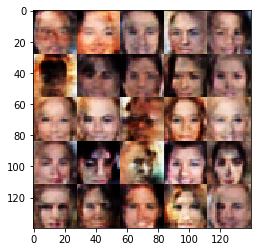

Epoch 1/1 --  Discriminator Loss: 1.4689 --  Generator Loss: 0.5928
Epoch 1/1 --  Discriminator Loss: 0.6839 --  Generator Loss: 1.5543
Epoch 1/1 --  Discriminator Loss: 0.6279 --  Generator Loss: 1.7168
Epoch 1/1 --  Discriminator Loss: 1.0270 --  Generator Loss: 1.1764
Epoch 1/1 --  Discriminator Loss: 1.4548 --  Generator Loss: 0.4665
Epoch 1/1 --  Discriminator Loss: 1.8129 --  Generator Loss: 1.5520
Epoch 1/1 --  Discriminator Loss: 1.0210 --  Generator Loss: 1.2281
Epoch 1/1 --  Discriminator Loss: 1.4330 --  Generator Loss: 0.6173
Epoch 1/1 --  Discriminator Loss: 1.7796 --  Generator Loss: 2.7693
Epoch 1/1 --  Discriminator Loss: 1.1259 --  Generator Loss: 1.4280


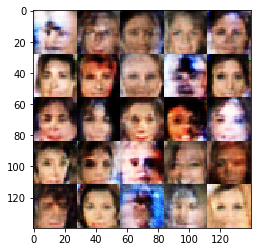

Epoch 1/1 --  Discriminator Loss: 1.0301 --  Generator Loss: 1.1179
Epoch 1/1 --  Discriminator Loss: 1.8334 --  Generator Loss: 0.2494
Epoch 1/1 --  Discriminator Loss: 1.1804 --  Generator Loss: 0.7500
Epoch 1/1 --  Discriminator Loss: 1.4355 --  Generator Loss: 0.4766
Epoch 1/1 --  Discriminator Loss: 1.5945 --  Generator Loss: 0.4331
Epoch 1/1 --  Discriminator Loss: 0.7879 --  Generator Loss: 1.4056
Epoch 1/1 --  Discriminator Loss: 0.9452 --  Generator Loss: 1.0013
Epoch 1/1 --  Discriminator Loss: 1.6778 --  Generator Loss: 0.3563
Epoch 1/1 --  Discriminator Loss: 1.4299 --  Generator Loss: 0.6816
Epoch 1/1 --  Discriminator Loss: 0.9215 --  Generator Loss: 1.3183


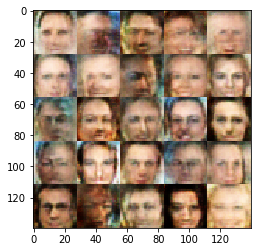

Epoch 1/1 --  Discriminator Loss: 1.2288 --  Generator Loss: 0.8598
Epoch 1/1 --  Discriminator Loss: 1.3578 --  Generator Loss: 2.1950
Epoch 1/1 --  Discriminator Loss: 0.6409 --  Generator Loss: 2.7009
Epoch 1/1 --  Discriminator Loss: 1.0986 --  Generator Loss: 1.4987
Epoch 1/1 --  Discriminator Loss: 1.6809 --  Generator Loss: 0.5523
Epoch 1/1 --  Discriminator Loss: 0.9140 --  Generator Loss: 1.2357
Epoch 1/1 --  Discriminator Loss: 1.9985 --  Generator Loss: 2.9662
Epoch 1/1 --  Discriminator Loss: 1.0060 --  Generator Loss: 1.1709
Epoch 1/1 --  Discriminator Loss: 1.3537 --  Generator Loss: 0.7803
Epoch 1/1 --  Discriminator Loss: 0.7038 --  Generator Loss: 1.9313


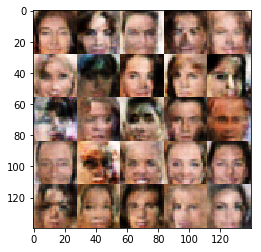

Epoch 1/1 --  Discriminator Loss: 1.3661 --  Generator Loss: 1.3474
Epoch 1/1 --  Discriminator Loss: 0.9774 --  Generator Loss: 0.9738
Epoch 1/1 --  Discriminator Loss: 1.1986 --  Generator Loss: 0.6557
Epoch 1/1 --  Discriminator Loss: 0.9377 --  Generator Loss: 0.9048
Epoch 1/1 --  Discriminator Loss: 0.9545 --  Generator Loss: 1.0969
Epoch 1/1 --  Discriminator Loss: 1.0565 --  Generator Loss: 0.6715
Epoch 1/1 --  Discriminator Loss: 1.5427 --  Generator Loss: 1.8524
Epoch 1/1 --  Discriminator Loss: 1.5714 --  Generator Loss: 2.9583
Epoch 1/1 --  Discriminator Loss: 0.4770 --  Generator Loss: 3.5074
Epoch 1/1 --  Discriminator Loss: 0.9707 --  Generator Loss: 1.0552


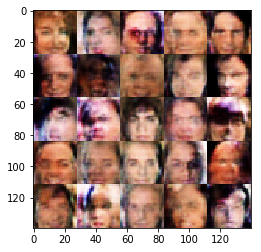

Epoch 1/1 --  Discriminator Loss: 0.4860 --  Generator Loss: 2.8920
Epoch 1/1 --  Discriminator Loss: 1.2445 --  Generator Loss: 0.7216
Epoch 1/1 --  Discriminator Loss: 0.6730 --  Generator Loss: 1.8243
Epoch 1/1 --  Discriminator Loss: 1.0977 --  Generator Loss: 1.9475
Epoch 1/1 --  Discriminator Loss: 0.9667 --  Generator Loss: 1.3296
Epoch 1/1 --  Discriminator Loss: 0.9871 --  Generator Loss: 0.9329
Epoch 1/1 --  Discriminator Loss: 1.4443 --  Generator Loss: 1.2774
Epoch 1/1 --  Discriminator Loss: 1.2542 --  Generator Loss: 0.5380
Epoch 1/1 --  Discriminator Loss: 1.6914 --  Generator Loss: 0.4900
Epoch 1/1 --  Discriminator Loss: 1.4162 --  Generator Loss: 1.5120


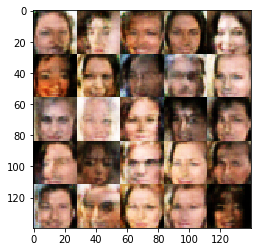

Epoch 1/1 --  Discriminator Loss: 1.3288 --  Generator Loss: 0.4816
Epoch 1/1 --  Discriminator Loss: 1.0998 --  Generator Loss: 0.6751
Epoch 1/1 --  Discriminator Loss: 0.5165 --  Generator Loss: 2.2123
Epoch 1/1 --  Discriminator Loss: 1.4124 --  Generator Loss: 0.6515
Epoch 1/1 --  Discriminator Loss: 1.2774 --  Generator Loss: 0.4865
Epoch 1/1 --  Discriminator Loss: 1.2015 --  Generator Loss: 0.8154
Epoch 1/1 --  Discriminator Loss: 0.7207 --  Generator Loss: 3.0954
Epoch 1/1 --  Discriminator Loss: 0.9245 --  Generator Loss: 2.9916
Epoch 1/1 --  Discriminator Loss: 0.5096 --  Generator Loss: 2.2139
Epoch 1/1 --  Discriminator Loss: 1.1452 --  Generator Loss: 0.8670


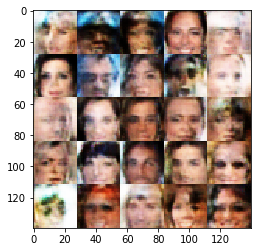

Epoch 1/1 --  Discriminator Loss: 0.6022 --  Generator Loss: 1.8382
Epoch 1/1 --  Discriminator Loss: 1.1223 --  Generator Loss: 0.8809
Epoch 1/1 --  Discriminator Loss: 1.1518 --  Generator Loss: 0.7560
Epoch 1/1 --  Discriminator Loss: 0.7946 --  Generator Loss: 1.3268
Epoch 1/1 --  Discriminator Loss: 1.2968 --  Generator Loss: 0.6880
Epoch 1/1 --  Discriminator Loss: 0.6540 --  Generator Loss: 1.6166
Epoch 1/1 --  Discriminator Loss: 1.1283 --  Generator Loss: 1.4650
Epoch 1/1 --  Discriminator Loss: 1.4046 --  Generator Loss: 0.6472
Epoch 1/1 --  Discriminator Loss: 1.4751 --  Generator Loss: 1.9451
Epoch 1/1 --  Discriminator Loss: 1.1167 --  Generator Loss: 0.8139


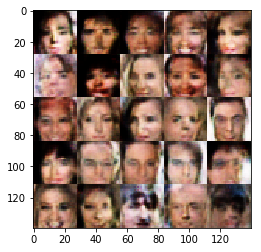

Epoch 1/1 --  Discriminator Loss: 1.8636 --  Generator Loss: 2.8570
Epoch 1/1 --  Discriminator Loss: 1.2518 --  Generator Loss: 0.8422
Epoch 1/1 --  Discriminator Loss: 1.0126 --  Generator Loss: 1.2205
Epoch 1/1 --  Discriminator Loss: 1.1477 --  Generator Loss: 0.7972
Epoch 1/1 --  Discriminator Loss: 0.8952 --  Generator Loss: 0.7600
Epoch 1/1 --  Discriminator Loss: 1.7706 --  Generator Loss: 3.0519
Epoch 1/1 --  Discriminator Loss: 1.3748 --  Generator Loss: 0.6301
Epoch 1/1 --  Discriminator Loss: 1.1504 --  Generator Loss: 1.1093
Epoch 1/1 --  Discriminator Loss: 1.0859 --  Generator Loss: 0.8250
Epoch 1/1 --  Discriminator Loss: 0.5893 --  Generator Loss: 2.3400


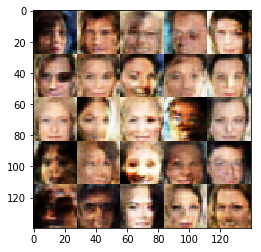

Epoch 1/1 --  Discriminator Loss: 0.5521 --  Generator Loss: 2.6043
Epoch 1/1 --  Discriminator Loss: 1.1097 --  Generator Loss: 1.2591
Epoch 1/1 --  Discriminator Loss: 1.1685 --  Generator Loss: 1.0416
Epoch 1/1 --  Discriminator Loss: 0.5964 --  Generator Loss: 1.8710
Epoch 1/1 --  Discriminator Loss: 0.8659 --  Generator Loss: 1.5472
Epoch 1/1 --  Discriminator Loss: 1.1549 --  Generator Loss: 0.8256
Epoch 1/1 --  Discriminator Loss: 0.7660 --  Generator Loss: 0.9765
Epoch 1/1 --  Discriminator Loss: 1.2516 --  Generator Loss: 1.0145
Epoch 1/1 --  Discriminator Loss: 0.7825 --  Generator Loss: 3.2969
Epoch 1/1 --  Discriminator Loss: 0.7810 --  Generator Loss: 1.4150


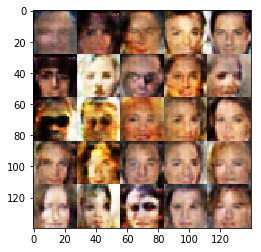

Epoch 1/1 --  Discriminator Loss: 1.4725 --  Generator Loss: 0.7371
Epoch 1/1 --  Discriminator Loss: 0.9146 --  Generator Loss: 0.8624
Epoch 1/1 --  Discriminator Loss: 0.9254 --  Generator Loss: 0.8610
Epoch 1/1 --  Discriminator Loss: 1.3653 --  Generator Loss: 0.4262
Epoch 1/1 --  Discriminator Loss: 0.8270 --  Generator Loss: 1.1435
Epoch 1/1 --  Discriminator Loss: 1.7791 --  Generator Loss: 1.6323
Epoch 1/1 --  Discriminator Loss: 1.2758 --  Generator Loss: 1.0647
Epoch 1/1 --  Discriminator Loss: 0.9608 --  Generator Loss: 1.0181
Epoch 1/1 --  Discriminator Loss: 0.8097 --  Generator Loss: 1.8719
Epoch 1/1 --  Discriminator Loss: 1.1414 --  Generator Loss: 0.6311


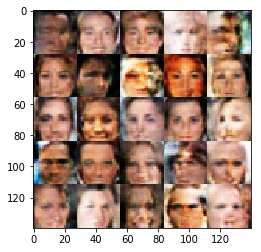

Epoch 1/1 --  Discriminator Loss: 0.9942 --  Generator Loss: 1.2142
Epoch 1/1 --  Discriminator Loss: 1.8185 --  Generator Loss: 1.5385
Epoch 1/1 --  Discriminator Loss: 1.2127 --  Generator Loss: 0.7385
Epoch 1/1 --  Discriminator Loss: 1.1655 --  Generator Loss: 0.4783
Epoch 1/1 --  Discriminator Loss: 1.0025 --  Generator Loss: 1.1619
Epoch 1/1 --  Discriminator Loss: 0.8416 --  Generator Loss: 2.3975
Epoch 1/1 --  Discriminator Loss: 1.3922 --  Generator Loss: 1.5372
Epoch 1/1 --  Discriminator Loss: 1.3538 --  Generator Loss: 0.4356
Epoch 1/1 --  Discriminator Loss: 1.1240 --  Generator Loss: 1.7967
Epoch 1/1 --  Discriminator Loss: 1.4517 --  Generator Loss: 0.7797


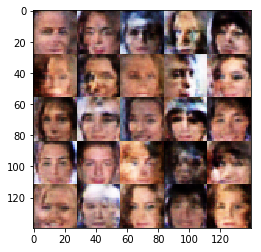

Epoch 1/1 --  Discriminator Loss: 0.9719 --  Generator Loss: 1.1735
Epoch 1/1 --  Discriminator Loss: 1.5261 --  Generator Loss: 0.4554
Epoch 1/1 --  Discriminator Loss: 0.9617 --  Generator Loss: 1.7530
Epoch 1/1 --  Discriminator Loss: 1.1967 --  Generator Loss: 1.3752
Epoch 1/1 --  Discriminator Loss: 0.6361 --  Generator Loss: 2.0039
Epoch 1/1 --  Discriminator Loss: 0.7643 --  Generator Loss: 1.3155
Epoch 1/1 --  Discriminator Loss: 1.2850 --  Generator Loss: 1.1632
Epoch 1/1 --  Discriminator Loss: 0.7952 --  Generator Loss: 1.5061
Epoch 1/1 --  Discriminator Loss: 1.2718 --  Generator Loss: 0.6634
Epoch 1/1 --  Discriminator Loss: 1.2243 --  Generator Loss: 1.7509


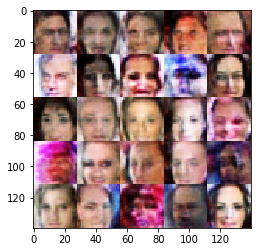

Epoch 1/1 --  Discriminator Loss: 1.6226 --  Generator Loss: 0.3949
Epoch 1/1 --  Discriminator Loss: 1.3144 --  Generator Loss: 0.6362
Epoch 1/1 --  Discriminator Loss: 1.0214 --  Generator Loss: 1.2088
Epoch 1/1 --  Discriminator Loss: 0.7128 --  Generator Loss: 1.3161
Epoch 1/1 --  Discriminator Loss: 1.1937 --  Generator Loss: 1.4137
Epoch 1/1 --  Discriminator Loss: 1.1681 --  Generator Loss: 0.7493


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.